# ML Project

## Data Exploration

In [43]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import scipy as scipy
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_roc_curve,plot_confusion_matrix, mean_squared_error, RocCurveDisplay, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [44]:
#define X and y from the relevant values in the csv file

data = pd.read_csv('train.csv', index_col=0)
X = data.drop(columns=['purchase'])
y = data['purchase']
print(f'X_train.shape: {X.shape}, y_train.shape: {y.shape}')
X_test = pd.read_csv('test.csv', index_col=0)

X_train.shape: (10479, 21), y_train.shape: (10479,)


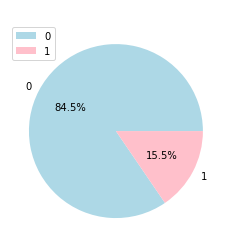

In [45]:
#See the distribution of the label column ("purchase")

label0 = y.value_counts()[0]/float(y.shape[0]) 
label1 = y.value_counts()[1]/float(y.shape[0])
labels = '0', '1'                                                                                    
fig1, ax1 = plt.subplots()
ax1.pie([label0, label1], labels = labels, colors = ["lightblue","pink"], autopct = '%1.1f%%')
plt.title('Label Distribution', color = 'white')                          
plt.legend(labels,loc=2)                        
plt.show()

As we can see, the distribution of the labels is very imbalanced. 

Examine a small portion of the data:

In [46]:
X.head(15)

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.0,...,Feb,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN
1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,0.0,...,Feb,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN
2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,0.0,...,Feb,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN
3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,0.0,...,Feb,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN
4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.0,...,Feb,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN
5,0.0,0.0,0.0,0.0 minutes,2.0,NaN,NaN,0.000000,0.100000,0.0,...,Feb,2.0,NaN,2.0,Returning_Visitor,False,c_3,104.712405,log200,NaN
6,0.0,0.0,0.0,0.0 minutes,3.0,738.0 minutes,NaN,0.000000,0.022222,0.0,...,Feb,2.0,edge_96.0.1054.72,1.0,Returning_Visitor,False,c_2,89.786568,log404,NaN
7,0.0,0.0,0.0,0.0 minutes,3.0,395.0 minutes,395.000000,0.000000,0.066667,0.0,...,Feb,1.0,safari_15,3.0,Returning_Visitor,False,c_3,101.184534,log_100,NaN
8,NaN,0.0,0.0,0.0 minutes,16.0,407.75 minutes,NaN,0.018750,0.025833,0.0,...,Feb,1.0,safari_15.4,4.0,Returning_Visitor,False,NaN,83.931739,log_100,NaN


We can see that "total_duration" seems to sum the other 3 duration features (info page, admin page, product page). Also, some features need to be adjusted so we can analyze and engineer them properly and conveniently.

In [47]:
# checking how many features have numeric values and how many have categorical values

print("Features before change:\n" + "features with num values -", X.select_dtypes(include = np.number).shape[1])
print("features with string values -", 21 -X.select_dtypes(include = np.number).shape[1])


Features before change:
features with num values - 13
features with string values - 8


Now, we will do the neccecery manipulations in order to get proper values to work with in all the relevant numeric and categorical features:

In [48]:
# finding features that have only a few unique values and might be catgorical (but not boolean)

def find_cat(df):
    print("Features suspected as categorical:")
    for col in df.columns:
        if df[col].nunique()<15 and df[col].nunique()>2:
            print(col, "| Type", df[col].dtypes)
find_cat(X)

Features suspected as categorical:
closeness_to_holiday | Type float64
Month | Type object
device | Type float64
Region | Type float64
user_type | Type object
C | Type object


We chose to change the features "device" and "Region" to string type so they will be included in the categorical features. We changed the feature "Month" values to string numbers for our convenience. We kept the feature "closeness_to_holiday" numeric since although it has only a few unique values, the size of the values matter.

In [49]:
# deleting the string "minutes" from "info_page_duration" and "product_page_duration" columns and change values type to float
def del_minutes(X):
    X['info_page_duration'] = X['info_page_duration'].str.replace(' minutes', '')
    X['product_page_duration'] = X['product_page_duration'].str.replace(' minutes', '')
    X = X.astype({'info_page_duration':'float'})
    X = X.astype({'product_page_duration':'float'})
    return X

# changing the boolean values of "Weekend" feature to be 0 for false, 1 for true
def change_bool_to_num(X):
    X.Weekend = X.Weekend.replace({True: 1, False: 0})
    return X

# changing "Month" feature to type string 
def month_to_num(X):
    X['Month']=X['Month'].replace(regex={r'Jan': '1', 'Feb': '2', 'Mar': '3', 'Apr': '4','May': '5','June':'6', 'Jul': '7', 'Aug': '8', 'Sep': '9', 'Oct': '10', 'Nov': '11', 'Dec': '12'})
    return X

# changing categorical features which include numbers - from type int to string
def change_num_to_cat(X):
    for col in ['device', 'Region']:
        X[col] =  X[col].astype(str)
    return X

# main function for all changes neccecery for the initial preparation of the data
def prep_data(X):
    X = del_minutes(X)
    X = change_bool_to_num(X)
    X = change_num_to_cat(X)
    X = month_to_num(X)
    return X
    

X = prep_data(X)

In [50]:
# checking how many features have numeric values and how many have categorical values - after the data preperation

print("Features after change:\n" +"features with num values -", X.select_dtypes(include = np.number).shape[1])
print("features with string values -", 21 -X.select_dtypes(include = np.number).shape[1])


Features after change:
features with num values - 14
features with string values - 7


In [51]:
# describing the X_train data statistics for further analysis

X.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
num_of_admin_pages,9874,NaN,NaN,NaN,2.32196,3.33533,0,0,1,4,27
admin_page_duration,10066,NaN,NaN,NaN,80.4625,179.218,0,0,8,93,3398.75
num_of_info_pages,9792,NaN,NaN,NaN,0.502655,1.26581,0,0,0,0,24
info_page_duration,10162,NaN,NaN,NaN,34.3238,142.039,0,0,0,0,2549.38
num_of_product_pages,10076,NaN,NaN,NaN,31.8702,44.8163,0,7,18,38,705
product_page_duration,9858,NaN,NaN,NaN,1197.52,1954.95,0,183.5,598.442,1470.3,63973.5
total_duration,5726,NaN,NaN,NaN,1302.46,2039.31,0,221,677.851,1605.73,47850.9
BounceRates,10457,NaN,NaN,NaN,0.0218538,0.0481002,0,0,0.00296804,0.0166667,0.2
ExitRates,10453,NaN,NaN,NaN,0.0428591,0.048297,0,0.0142834,0.0251613,0.05,0.2
PageValues,10452,NaN,NaN,NaN,5.90039,18.7275,0,0,0,0,361.764


We can already see that there are features with many missing values (D for example). Also we see the features values are in different scales and we might want to normalize them later.

Counting the missing values in every feature:

In [52]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
data_type = X.dtypes
missing_data = pd.concat([total, percent, data_type], axis=1, keys=['Total Null', 'Percent Null', 'Data type'])
missing_data

,Total Null,Percent Null,Data type
D,10374,0.989980,float64
total_duration,4753,0.453574,float64
A,706,0.067373,object
num_of_info_pages,687,0.065560,float64
product_page_duration,621,0.059261,float64
num_of_admin_pages,605,0.057735,float64
internet_browser,563,0.053727,object
closeness_to_holiday,496,0.047333,float64
admin_page_duration,413,0.039412,float64
num_of_product_pages,403,0.038458,float64


### Visualizing Numeric Data ###

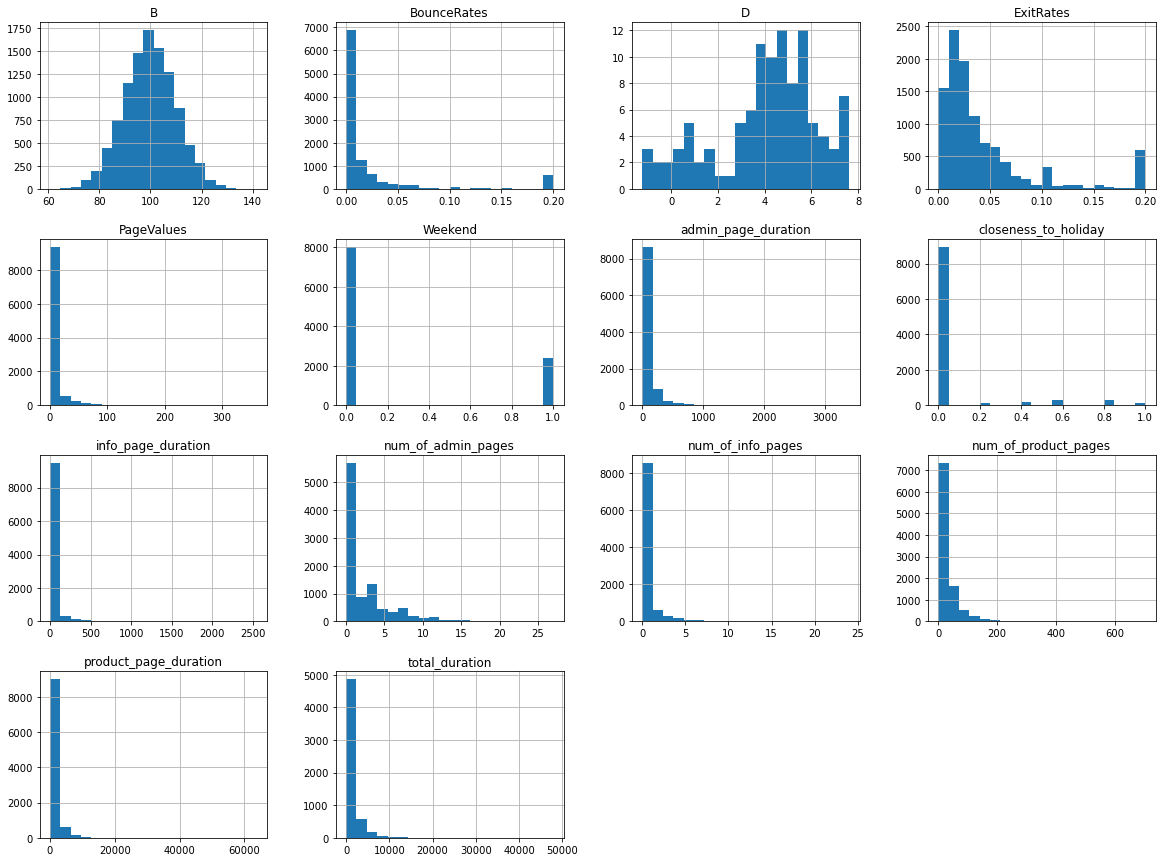

In [53]:
numeric_features = X.select_dtypes(include = np.number)
numeric_features.hist(bins =20, figsize = (20,15))
plt.show()

From the histograms we can see the way different features are distributed (for further conclusions). We noticed that many of the features distributions are very skewed. <br>
Let's check the corralations between the features with a corralation matrix:

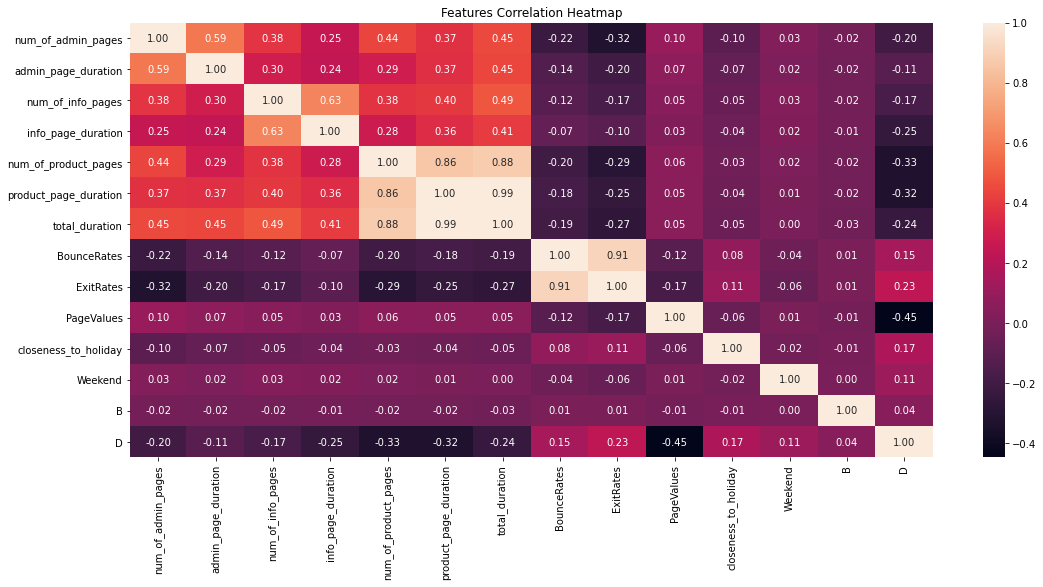

In [54]:
corr_mat = X.corr()
plt.figure(figsize=(18,8))
plt.title('Features Correlation Heatmap')
sns.heatmap(corr_mat,annot=True, fmt='.2f')
plt.show()

There are some features which are highly correlated: <br>
"total_duration" & "product_page_duration", <br>
 "ExitRates" & "BounceRates", <br>
"total_duration" & "num_of_product_pages",<br>
"product_page_duration" & "num_of_product_pages" 


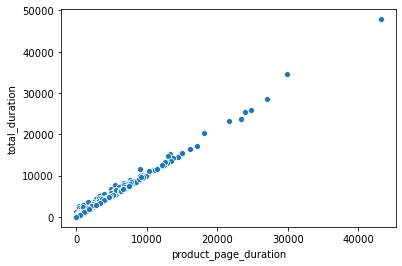

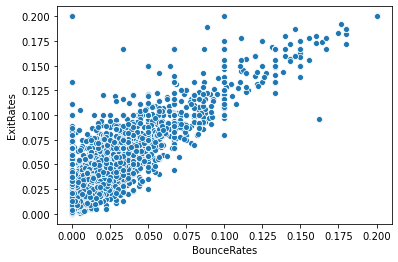

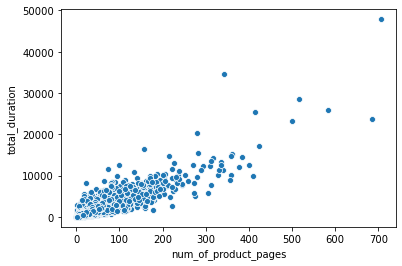

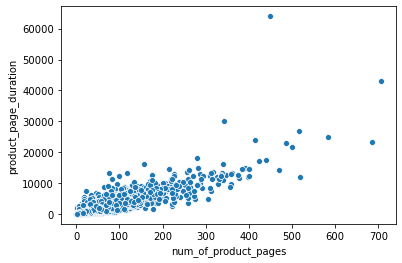

In [55]:
# plotting the high correlated features corralation

sns.scatterplot(x="product_page_duration", y="total_duration", data=X);
plt.show()
sns.scatterplot(x="BounceRates", y="ExitRates", data=X);
plt.show()
sns.scatterplot(x="num_of_product_pages", y="total_duration", data=X);
plt.show()
sns.scatterplot(x="num_of_product_pages", y="product_page_duration", data=X);
plt.show()

Checking and plotting the correlations between each numeric feature and the label:

In [56]:
pd.DataFrame(X.corrwith(y).sort_values(ascending=False)).rename(columns = {0: 'Corr_with_label'})

,Corr_with_label
PageValues,0.486404
num_of_product_pages,0.157167
product_page_duration,0.152133
total_duration,0.145429
num_of_admin_pages,0.145048
admin_page_duration,0.097504
num_of_info_pages,0.095563
info_page_duration,0.070309
Weekend,0.028725
B,-0.003981


<AxesSubplot:>

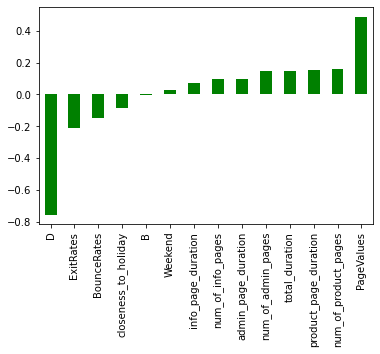

In [57]:
X.corrwith(y).sort_values(ascending=False).sort_values().plot(kind='bar', color = 'green')

D has the highest correlation with the label, BUT - we also saw before that it has many missing values (almost 99%!), so the high correlation can be misleading.

### Visualizing Categorical Data ###

In [58]:
categorical_features = X.select_dtypes(exclude=np.number)
categorical_features.columns

# checking how many unique categories there are for every categorical feature

for category in categorical_features:
   b = X[category].value_counts()
   print("Number of categories in feature '"+ category+ "':", len(b))

Number of categories in feature 'Month': 10
Number of categories in feature 'device': 9
Number of categories in feature 'internet_browser': 126
Number of categories in feature 'Region': 10
Number of categories in feature 'user_type': 3
Number of categories in feature 'A': 96
Number of categories in feature 'C': 6


From these results we can see that the features "internet_browser" & 'A' have many different categories, so we will plot them separately

Month:


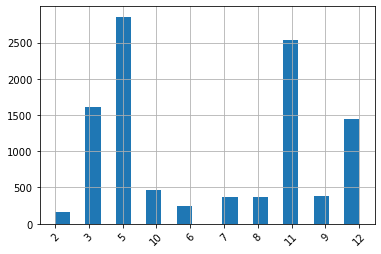

device:


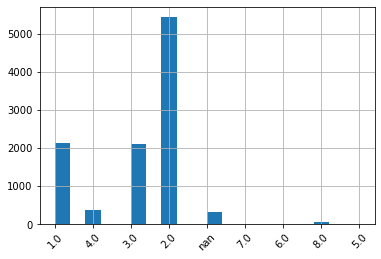

Region:


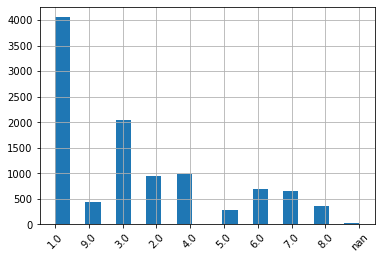

user_type:


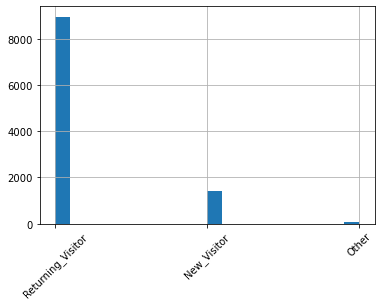

C:


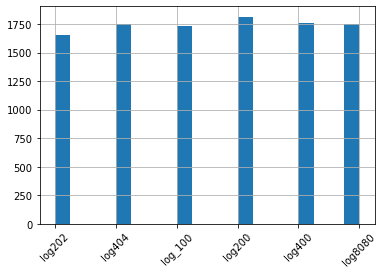

In [59]:
# plotting categorical features

for category in categorical_features:
    if category not in ['internet_browser', 'A']:
        print(category + ":")
        X[category].hist(bins=20)
        X[category].unique()
        plt.xticks(rotation = 45)
        plt.show()

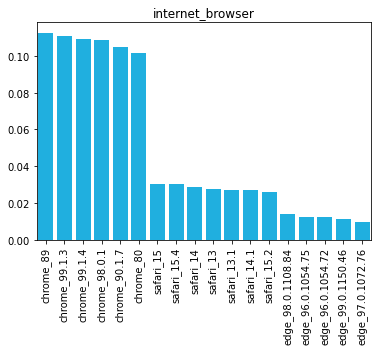

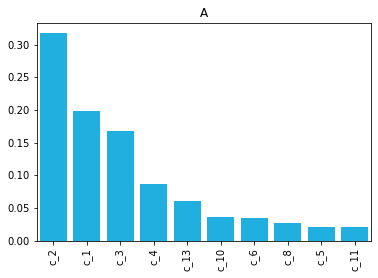

In [60]:
# plotting features with many different categories - with a threshold of 0.005 (lower frequencies then this don't represent the data)

for feat in ['internet_browser', 'A']:
    categ = X[feat].value_counts(normalize = True)
    categ = categ[categ > 0.005]
    sns.barplot(categ.index, categ.values, color= 'Deepskyblue')
    plt.title(feat)
    plt.xticks(rotation = 90)
    plt.show()


We noticed that the 'internet_browser' feature distribution is pretty similar for each kind of general browser (chrome, safari, edge).  <br>
We will want to minimize the number of categories in order to reduct the dimention

# Pre-prossesing
### Feature Engineering

Train and Validation split:

In [61]:
# split the data to train and validation (70% train, 30% validation)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3 ,random_state=42, shuffle = True)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}')


X_train shape: (7335, 21), y_train shape: (7335,)
X_validation shape: (3144, 21), y_validation shape: (3144,)


Fill missing values:

Based on the features distributions, we chose for each feature it's appropriate way to fill the missing values - Fow skewed distribution features we use the median, for normal distribution features we use the mean, for "total_duration" we sum the other duration features, for the rest we use frequent/random values. <br>
We chose to delete the feature "D" since filling it's missing values wouldn't make sense in a 99% missing values situation. <br>
We based the calculations on the train set data of course.

In [62]:
# filling the NA values with the median 
def fill_na_median(df, X_train):
    for col in ['admin_page_duration', "info_page_duration", "product_page_duration", 'num_of_product_pages', \
     'num_of_admin_pages', 'ExitRates', 'BounceRates', 'num_of_info_pages', 'PageValues']:
        median = X_train[col].median()
        df[col] = df[col].fillna(median)
    return df

# filling the NA values of 'total_duration' with the sum of all the duration features
def fill_na_sum_duration(df):
    df['total_duration'] = df['total_duration'].fillna(df['product_page_duration']+ df['admin_page_duration']+ df['info_page_duration'])
    return df

# filling the NA values with the most frequent value
def fill_na_freq(df, X_train):
    for col in ['closeness_to_holiday', 'A', 'user_type']:
        mode = X_train[col].value_counts().idxmax()
        df[col] = df[col].fillna(mode)
    return df

# filling the NA values with the mean value
def fill_na_mean(df, X_train):
    for col in ['B']:
        mean = X_train[col].mean()
        df[col] = df[col].fillna(mean)
    return df

# filling the NA values with a random value from the categories 
def fill_na_rand(df):
    for col in ['C', 'internet_browser', 'Month', 'Weekend', 'Region', 'device']:
        df[col] = df[col].apply(lambda x: np.random.choice(df[col].dropna().values) 
                                      if pd.isnull(x) else x)
    return df

# main function for filling NA values in data
def fill_na_main(df, X_train):
    df = fill_na_freq(df, X_train)
    df = fill_na_mean(df, X_train)
    df = fill_na_median(df, X_train)
    df = fill_na_rand(df)
    df = fill_na_sum_duration(df)
    df.drop('D', inplace = True, axis =1) ##dropping feature 'D' due to too many missing values
    return df

In [63]:
# filling missing values in the train & validation datasets

X_train = fill_na_main(X_train, X_train)
X_validation = fill_na_main(X_validation, X_train)

# checking that we no longer have missing values

total = X_train.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total], axis=1, keys=['Total_Null', 'Percent_Null', 'Data_type'])
missing_data

,Total_Null
C,0
B,0
admin_page_duration,0
num_of_info_pages,0
info_page_duration,0
num_of_product_pages,0
product_page_duration,0
total_duration,0
BounceRates,0
ExitRates,0


Creating new features

In [64]:
# creating a new feature that unite the 3 top kinds of internet browsers. browsers under the 0.005 threshold named "other"
# dropping the original 'internet_browser' feature

def create_browser_new(df):
    df['browser_new'] = df['internet_browser']
    df.browser_new = df.browser_new.apply(lambda cell: 'safari' if 'safari' in cell else cell)
    df.browser_new = df.browser_new.apply(lambda cell: 'edge' if 'edge' in cell else cell)
    df.browser_new = df.browser_new.apply(lambda cell: 'chrome' if 'chrome' in cell else cell)
    df.browser_new = df.browser_new.apply(lambda cell: 'other' if ('safari' not in cell) and ('edge' not in cell) and ('chrome' not in cell) else cell)
    df.drop('internet_browser', inplace = True, axis = 1)
    return df

# creating "A_new" feature - values with lower frequency than 0.005 named "other"
# dropping the original 'A' feature
def create_A_new(df):
    df['A_new'] = df['A']
    threshold = 0.005 
    value_counts = df['A'].value_counts(normalize = True) 
    to_remove = value_counts[value_counts < threshold].index.values
    df['A_new'].loc[df['A_new'].isin(to_remove)] = 'other'
    df.drop('A', inplace = True, axis =1)
    return df 

def new_features(df):
    df = create_browser_new(df)
    df = create_A_new(df)
    return df


X_train = new_features(X_train)
X_validation = new_features(X_validation)

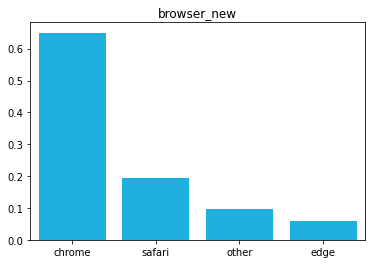

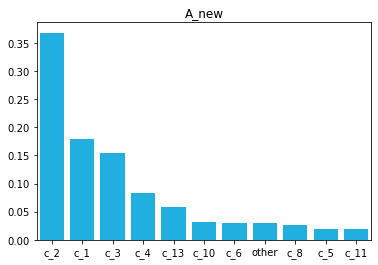

(7335, 20)

In [65]:
#plotting the new features made

check1 = X_train['browser_new'].value_counts(normalize = True)
sns.barplot(check1.index, check1.values, color= 'Deepskyblue')
plt.title('browser_new')
plt.show()

check2 = X_train['A_new'].value_counts(normalize = True)
sns.barplot(check2.index, check2.values, color= 'Deepskyblue')
plt.title('A_new')
plt.show()


X_train.shape

Handling features with high correlation -  Dropping one of the features in which their correlation is higher than 90%:

In [66]:
def delete_corr_features(df):
    df.drop('product_page_duration', axis = 1, inplace = True)
    df.drop('BounceRates', axis = 1, inplace = True)
    return df

X_train = delete_corr_features(X_train)
X_validation = delete_corr_features(X_validation)

Log transformation for skewed distributed data - Since the algorithm is more likely to be biased when the data distribution is skewed:

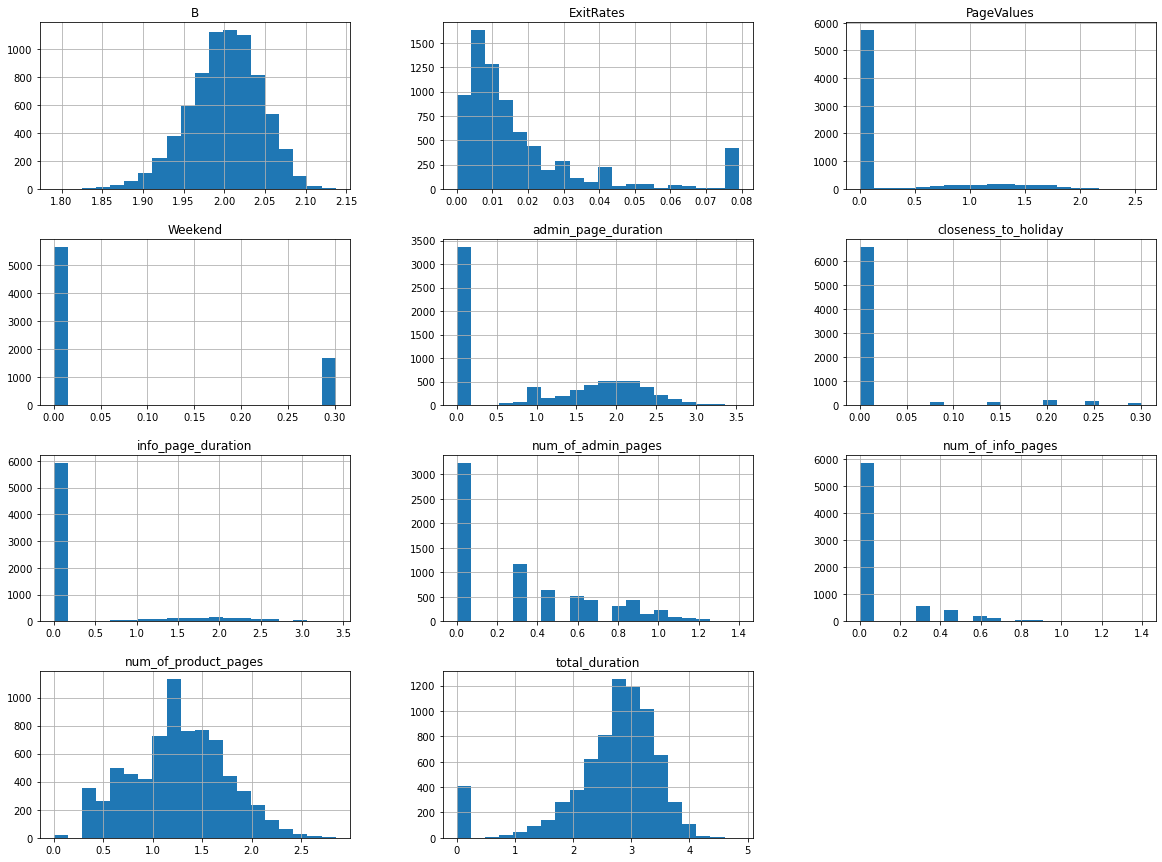

In [67]:
numeric_features.drop(['D', 'BounceRates', 'product_page_duration'], inplace = True, axis = 1)
log_var = numeric_features.columns

def log_transformation(df):
     for j in range(len(log_var)):
          var = log_var[j]
          df[var] = np.log10(df[var]+1)
     return df

X_train = log_transformation(X_train)
X_validation = log_transformation(X_validation)


X_train[log_var].hist(bins =20, figsize = (20,15))
plt.show()

Now we can see that the features are a bit more normally distributed. Let's box plot the transformed features to look for outliers:

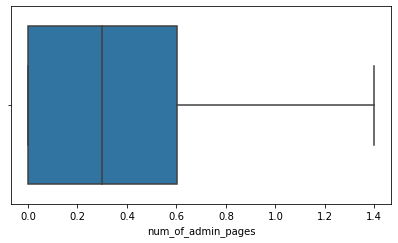

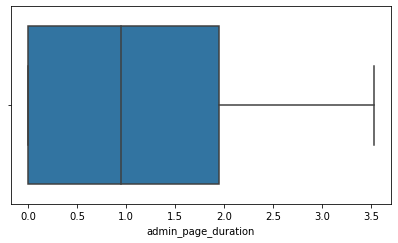

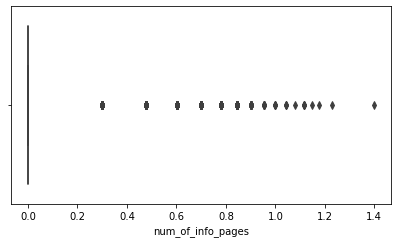

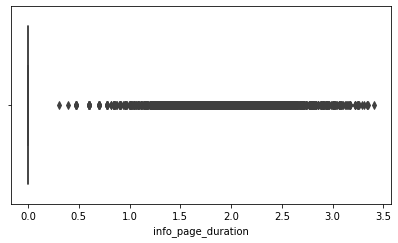

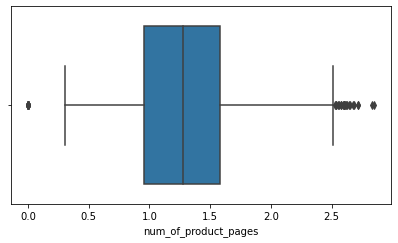

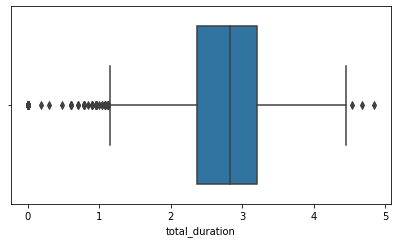

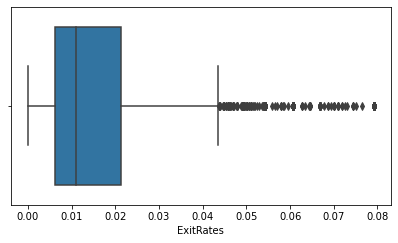

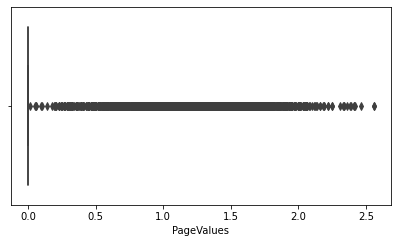

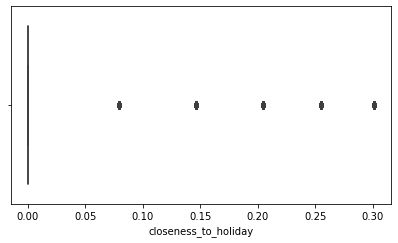

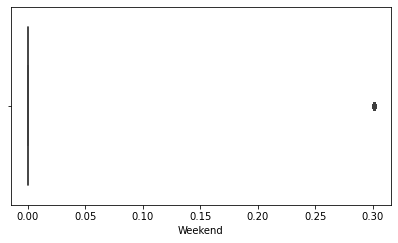

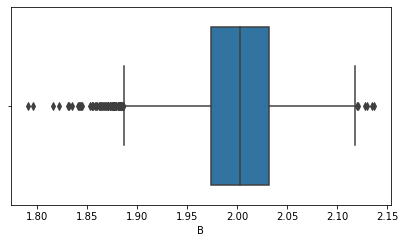

In [68]:
for feature in log_var:
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,2)
    sns.boxplot(X_train[feature])

Clipping - Handeling Outliers:

In [69]:
# after looking at the boxplots, we chose the features that seems to have outliers and that we want to clip 

def clipping(df):

    clip_var = ['num_of_info_pages', 'info_page_duration', 'num_of_product_pages', 'total_duration', 'PageValues', 'ExitRates', 'B']
    for i in clip_var:
    # upper limit - .95 quantile
        upper_limit = df[i].quantile(0.95)
    # lower limit - .05 quantile
        lower_limit = df[i].quantile(0.05)
        df[i] = df[i].clip(lower_limit, upper_limit, axis = 0)
                
    return df

X_train = clipping(X_train)

Scaling the data and preforming get_dummies function for categorical features:

Most of the numeric features aren't scaled yet - we will scale them to improve the PCA and the model performance. <br>
We will use RobustScaler which is more suitable for dataset with skewed distributions because it transforms the data based on median and quantile.

In [70]:
def scaling(X_train_fit,df):
    numeric_X_train = X_train_fit.select_dtypes(include = np.number)
    numeric_df = df.select_dtypes(include = np.number)
   # mod = StandardScaler()
   # mod = MinMaxScaler()
    mod = RobustScaler()
    mod.fit(numeric_X_train)
    transformation = mod.transform(numeric_df)
    scaled_df = pd.DataFrame(data=transformation,index=numeric_df.index,columns=numeric_df.columns) # change the array to a dataframe
    return scaled_df 

def dummies(df):
    dummies = pd.get_dummies(df.select_dtypes(include=object))
    return dummies

# creating main function for joining the scaling and the dummies functions
def join_scale_dummies(X_train_fit, df):
    scaled_df = scaling(X_train_fit, df)
    dummy_df = dummies(df)
    full_df = scaled_df.join(dummy_df)
    return full_df


scaled_X_train_with_dummies = join_scale_dummies(X_train, X_train)
scaled_X_val_with_dummies = join_scale_dummies(X_train, X_validation)

scaled_X_train_with_dummies.shape

(7335, 64)

After the get_dummies function, we now have 64 features.

## Feature Selection ##

PCA:

In [71]:
# creating a PCA function to reduct dimentions (fitting on the train set)

def pca(X_train_fit, df):
    pca = PCA(n_components=0.95)  #0.95 percent of explained variance
    pca.fit(X_train_fit) 
    df = pd.DataFrame(pca.transform(df))
    return df

new_X_train = pca(scaled_X_train_with_dummies, scaled_X_train_with_dummies)
new_X_val = pca(scaled_X_train_with_dummies, scaled_X_val_with_dummies)
new_X_train.head()


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1.441342,0.962959,-0.475724,0.186729,0.021532,-0.151440,-0.074900,-0.347306,-1.166592,0.095192,...,-0.048407,0.007604,0.022261,-0.116799,-0.016440,0.069082,-0.103691,0.036524,-0.010707,-0.074323
1,-0.698263,-0.478465,1.291387,-0.198635,-0.573033,0.037155,0.175158,-1.059189,-0.055128,0.130486,...,-0.011333,-0.009416,0.025047,-0.017215,0.011022,0.027326,-0.035892,-0.069524,-0.024052,-0.088084
2,-1.049966,0.606027,0.998268,0.603240,-1.522131,1.099385,0.130822,0.031810,-1.273459,0.314565,...,-0.047195,0.031073,0.009669,-0.086071,-0.001040,0.037583,-0.020042,-0.096764,0.005960,-0.079270
3,1.405890,-0.654988,-0.395471,-0.127533,0.751404,0.695749,-0.142919,0.293776,-0.777433,0.118726,...,-0.005110,-0.049055,0.008811,-0.101740,0.064528,-0.048569,-0.135624,0.014751,-0.105630,0.006374
4,-1.361926,1.220065,0.170070,1.310263,0.219524,0.335718,-1.112194,0.464236,-0.070653,0.936868,...,0.210897,-0.659670,-0.794599,0.274249,0.379250,-0.105076,-0.101210,-0.195094,0.241282,0.230302


## Models

Running the models with grid search function to find the best parametes:

In [72]:
"""#Random Forest Classifier
clf_rfC = RandomForestClassifier()

param_grid_rfC = {'criterion':['gini','entropy'],
                        'max_depth':[5,8,10,12,15],
                        "n_estimators":[ 150, 200,250,300,350],
                        "class_weight": ['balanced'],
                        'random_state': [0]}  

                        
optimizer_rfC = GridSearchCV(clf_rfC ,param_grid_rfC, cv=5,scoring = 'roc_auc', n_jobs=-1)
optimizer_rfC.fit(new_X_train,y_train) 

best_params_rfC = optimizer_rfC.best_params_
print('Best parameters:', best_params_rfC)
print('Best score:', optimizer_rfC.best_score_)
"""

'#Random Forest Classifier\nclf_rfC = RandomForestClassifier()\n\nparam_grid_rfC = {\'criterion\':[\'gini\',\'entropy\'],\n                        \'max_depth\':[5,8,10,12,15],\n                        "n_estimators":[ 150, 200,250,300,350],\n                        "class_weight": [\'balanced\'],\n                        \'random_state\': [0]}  \n\n                        \noptimizer_rfC = GridSearchCV(clf_rfC ,param_grid_rfC, cv=5,scoring = \'roc_auc\', n_jobs=-1)\noptimizer_rfC.fit(new_X_train,y_train) \n\nbest_params_rfC = optimizer_rfC.best_params_\nprint(\'Best parameters:\', best_params_rfC)\nprint(\'Best score:\', optimizer_rfC.best_score_)\n'

In [73]:
"""# KNN

clf_knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [5,10,15,50,100,150,200],
              'weights': ['uniform', 'distance'],
              'p': [1,2],
              'metric': ['minkowski', 'euclidean', 'manhattan']
             }

optimizer_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5,scoring = 'roc_auc', n_jobs=-1)
optimizer_knn.fit(new_X_train,y_train)

best_params_knn = optimizer_knn.best_params_
print('Best parameters:', best_params_knn)
print('Best score:', optimizer_knn.best_score_)
"""

"# KNN\n\nclf_knn = KNeighborsClassifier()\nparam_grid_knn = {'n_neighbors': [5,10,15,50,100,150,200],\n              'weights': ['uniform', 'distance'],\n              'p': [1,2],\n              'metric': ['minkowski', 'euclidean', 'manhattan']\n             }\n\noptimizer_knn = GridSearchCV(clf_knn, param_grid_knn, cv=5,scoring = 'roc_auc', n_jobs=-1)\noptimizer_knn.fit(new_X_train,y_train)\n\nbest_params_knn = optimizer_knn.best_params_\nprint('Best parameters:', best_params_knn)\nprint('Best score:', optimizer_knn.best_score_)\n"

In [74]:
"""# SVM

clf_svm = svm.SVC()

param_grid_svm = {
    'kernel': ['rbf', 'poly'],
    'C': [5,10,15,20,25],
    'gamma': [1, 0.1, 0.01, 0.001],
    'class_weight': ['balanced']
}

optimizer_svm = GridSearchCV(clf_svm, param_grid_svm,scoring='roc_auc', cv=5,n_jobs=-1)
optimizer_svm.fit(new_X_train,y_train)

best_params_svm = optimizer_svm.best_params_
print('Best parameters:', best_params_svm)
print('Best score:', optimizer_svm.best_score_)
"""

"# SVM\n\nclf_svm = svm.SVC()\n\nparam_grid_svm = {\n    'kernel': ['rbf', 'poly'],\n    'C': [5,10,15,20,25],\n    'gamma': [1, 0.1, 0.01, 0.001],\n    'class_weight': ['balanced']\n}\n\noptimizer_svm = GridSearchCV(clf_svm, param_grid_svm,scoring='roc_auc', cv=5,n_jobs=-1)\noptimizer_svm.fit(new_X_train,y_train)\n\nbest_params_svm = optimizer_svm.best_params_\nprint('Best parameters:', best_params_svm)\nprint('Best score:', optimizer_svm.best_score_)\n"

In [75]:
"""# Logistic Regression

clf_lg = LogisticRegression()
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.01,0.1, 1, 2],
    'solver': ['saga', 'liblinear', 'lbfgs', 'sag'],
    'class_weight': ['balanced']
} 

optimizer_lg = GridSearchCV(clf_lg, param_grid,scoring='roc_auc',n_jobs=4, cv =5)
optimizer_lg.fit(new_X_train,y_train)

best_params_lg = optimizer_lg.best_params_
print('Best parameters:', best_params_lg)
print('Best score:', optimizer_lg.best_score_)
"""

"# Logistic Regression\n\nclf_lg = LogisticRegression()\nparam_grid = {\n    'penalty': ['l1','l2'],\n    'C': [0.01,0.1, 1, 2],\n    'solver': ['saga', 'liblinear', 'lbfgs', 'sag'],\n    'class_weight': ['balanced']\n} \n\noptimizer_lg = GridSearchCV(clf_lg, param_grid,scoring='roc_auc',n_jobs=4, cv =5)\noptimizer_lg.fit(new_X_train,y_train)\n\nbest_params_lg = optimizer_lg.best_params_\nprint('Best parameters:', best_params_lg)\nprint('Best score:', optimizer_lg.best_score_)\n"

Defining the models with chosen parameters:

In [76]:
## running the models with the best parameters found with GridSearch 

# SVM
clf_svm = svm.SVC(C= 15, class_weight= 'balanced', gamma= 0.01, kernel= 'rbf', probability= True)

# Logistic Regression
clf_lg = LogisticRegression(C= 0.1, class_weight= 'balanced', penalty= 'l1', solver= 'liblinear')

# KNN
clf_knn = KNeighborsClassifier(metric= 'minkowski', n_neighbors= 100, p= 2, weights= 'distance')

# Random Forest Classifier
clf_rfC = RandomForestClassifier(class_weight= 'balanced', criterion= 'entropy', max_depth= 15, n_estimators= 350, random_state= 0)



## Model Evaluation

Confusion matrix for SVM:

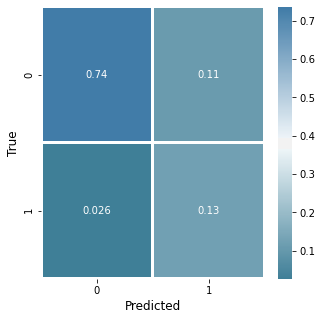

weighted accuracy: 0.7796317606444189


In [77]:
def Confusion_Mat (true, predicted):
    clf_cm = confusion_matrix(true, predicted)
    tn, fp, fn, tp = clf_cm.ravel()
    precentage = clf_cm/float(len(true))
    f, ax = plt.subplots(figsize=(5, 5))
    diverge = sns.diverging_palette(225, 240, n=10, as_cmap=True)                                                     
    sns.heatmap(precentage, annot=True, cmap=diverge, linewidths=2)

    ax.set_xlabel('Predicted', size = 12)
    ax.set_ylabel('True', size = 12)
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()

    acc_weighted = (tn + tp)/(tn + tp + fp + 5*fn)
    return acc_weighted

clf_svm.fit(new_X_train,y_train)
print("weighted accuracy:", Confusion_Mat(y_validation, clf_svm.predict(new_X_val)))


From the confusion matrix we can see that for SVM model on out data there is ~74% of true negative predictions, and ~13% of true positive predictions.  <br>
Of course we're not perfect (yet), and so we can see that we have ~11% false positive predictions, and ~2.6% of false negative predictions.

Building pipeline function to preform on the full X_train data set to use it in K-Fold Cross Validation:

In [78]:
def full_train_set_prep(df, y_train_full):
    df = fill_na_main(df, df)
    df = new_features(df)
    df = delete_corr_features(df)
    df = log_transformation(df)
    #df, y_train_full = remove_outliers(df, y_train_full)
    scaled_X_train = join_scale_dummies(df, df)
    X_train_ready = pca(scaled_X_train, scaled_X_train)
    return X_train_ready, scaled_X_train, y_train_full

In [79]:
X_copy = X.copy()
X_train_ready, scaled_X_train, y_train_ready = full_train_set_prep(X_copy, y)

Plotting ROC curves with K-Fold Cross Validation, <br>
Checking if the models are overfitted:

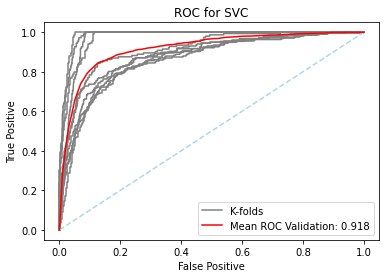

Validation AUC: 0.917640452169514 
Train AUC: 0.9376226894613293
Difference: 0.019982237291815363
The model is not overfittiמg, Great!


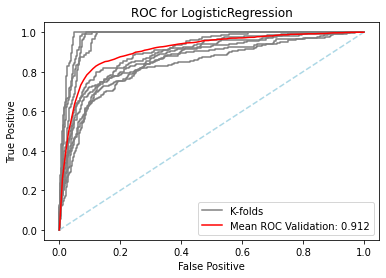

Validation AUC: 0.9117239762861258 
Train AUC: 0.9218318712336695
Difference: 0.010107894947543716
The model is not overfittiמg, Great!


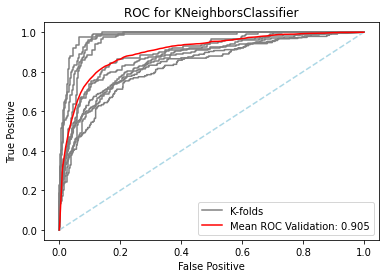

Validation AUC: 0.9053946516007725 
Train AUC: 0.995
Difference: 0.08960534839922751
The model is not overfittiמg, Great!


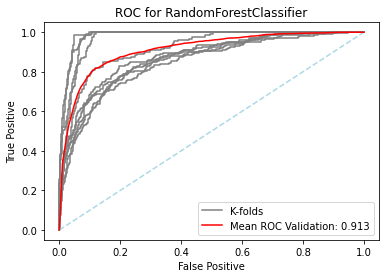

Validation AUC: 0.9133597146193231 
Train AUC: 0.995
Difference: 0.08164028538067691
The model is not overfittiמg, Great!


In [80]:
def KfoldCrossValidation(X, y, k, lst_clf):
    aucs = []
    for clf in lst_clf:
        kfold = KFold(n_splits=k)
        avg_tpr_train= avg_tpr_val = 0
        avg_fpr_train = avg_fpr_val = np.linspace(0, 1, 101)
        
        for train_id, val_id in kfold.split(X):
            X_train, X_val, y_train, y_val = X.iloc[train_id], X.iloc[val_id],y.iloc[train_id], y.iloc[val_id]
            clf.fit(X_train, y_train)

            fpr_train, tpr_train, thresholds_t = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
            fpr_val, tpr_val, thresholds_v = roc_curve(y_val, clf.predict_proba(X_val)[:, 1])

            avg_tpr_train+= np.interp(avg_fpr_train, fpr_train, tpr_train)
            avg_tpr_val += np.interp(avg_fpr_val, fpr_val, tpr_val)
            avg_tpr_val[0] =  avg_tpr_train[0] = 0

            plt.plot(fpr_val, tpr_val, color='gray')

        plt.plot([0], [0], color='gray', label='K-folds')    

        avg_tpr_train/= k
        avg_tpr_train[-1] = 1.0
        mean_auc_train = auc(avg_fpr_train, avg_tpr_train)

        avg_tpr_val /= k
        avg_tpr_val[-1] = 1.0
        mean_auc_val = auc(avg_fpr_val, avg_tpr_val)

        difference = np.abs(mean_auc_val - mean_auc_train)

        plt.plot([0, 1], [0, 1], color='lightblue', linestyle='--')
        plt.plot(avg_fpr_val, avg_tpr_val, color='red', linestyle = '-', label='Mean ROC Validation: %0.3f' % mean_auc_val)
        plt.xlabel('False Positive')
        plt.ylabel('True Positive')
        plt.title('ROC for %s' %str(type(clf)).strip("'>").split(".")[-1])
        plt.legend()
        plt.show()

        print("Validation AUC:",mean_auc_val,"\nTrain AUC:",mean_auc_train)
        print("Difference:", difference)
        if difference > 0.1:
            print("The model", type(clf).__name__, "is overfitting.")
        else:
            print('The model is not overfittiמg, Great!')

clf_list = [clf_svm, clf_lg, clf_knn, clf_rfC]
KfoldCrossValidation(X_train_ready,y_train_ready,10,clf_list)

### Running the model on the test set

In [81]:
# reading the csv file and dividing the data

data = pd.read_csv('train.csv', index_col=0)
X = data.drop(columns=['purchase'])
y = data['purchase']
X_test = pd.read_csv('test.csv', index_col=0)

In [82]:
# pipeline for the train set 

def full_train_set_prep(df, y_train_full):
    df = fill_na_main(df, df)
    df = new_features(df)
    df = delete_corr_features(df)
    df = log_transformation(df)
    #df, y_train_full = remove_outliers(df, y_train_full)
    scaled_X_train = join_scale_dummies(df, df)
    X_train_ready = pca(scaled_X_train, scaled_X_train)
    return X_train_ready, scaled_X_train, y_train_full

# pipeline for the test set 

def test_set_prep(df, X_copy, X_train_fit, scaled_X_train):
    df = prep_data(df)
    df = fill_na_main(df, X_copy)
    df = new_features(df)
    df = delete_corr_features(df)
    df = log_transformation(df)
    scaled_X_test = join_scale_dummies(X_train_fit, df)
    X_test_ready = pca(scaled_X_train, scaled_X_test)
    return X_test_ready

In [83]:
# preprocessing the train and the test data sets (fill NA, create new features, log transformation, reduce dimentions etc.)

X = prep_data(X)
X_copy = X.copy()

X_train_ready, scaled_X_train, y_train_ready = full_train_set_prep(X, y)
X_test_ready = test_set_prep(X_test, X_copy, X, scaled_X_train)

Fitting the chosen model & Making predictions:

In [84]:
clf_svm = svm.SVC(C= 20, class_weight= 'balanced', gamma= 0.01, kernel= 'rbf', probability= True)
clf_svm.fit(X_train_ready,y)

print('Accuracy score:', clf_svm.score(X_train_ready,y))


predictions = pd.DataFrame(clf_svm.predict_proba(X_test_ready)[:,1])
pd.DataFrame(predictions).to_csv('Submission_group_10.csv', header = ['predict_prob'], index_label= 'id')


Accuracy score: 0.8762286477717339
